In [1]:
version = "v1.11.012921"

# SIADS 543 Assignment 1: Introduction to Unsupervised Learning

In this week's assignment you'll gain experience applying dimensionality reduction, manifold learning, and density estimation techniques. With these examples, you'll see how they can help gain insight into new datasets, and extract potential new features for additional machine learning steps such as clustering or training a classifier.

*Please note that for autograder messages that check a list, it will typically report any problems using a list index starting at zero, i.e. the first list element is called "element 0".*

In [2]:
# First import some necessary libararies 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision = 3)

heart_dataset = './assets/mads_SAHeart.csv'
beer_dataset  = './assets/beer2.csv'

## Question 1.  Principal Components Analysis (40 points)

In this question you'll use PCA to explore a new dataset of beer ratings and reviews. The goal is to gain experience using PCA and related tools such as a biplot to get insight into the data, especially how ratings can be explained via a smaller number of latent factors.

Each row of the dataset corresponds to one beer review. 

Each beer is reviewed on a scale from 1 to 5 using these variables:

`review_appearance` :: How appealing is the color, clarity of the beer?

`review_aroma` :: How appealing is the aroma?

`review_palate` :: How appealing is the "palate": the combination of carbonation, mouthfeel, alcohol profile and texture? 

`review_taste` :: How appealing is the taste - e.g. is there a good balance of sweet and bitter?

`review_overall` :: How appealing is the overall experience of drinking this beer?

Each beer record also has several other columns, the most important of which are:

`beer_index` :: unique row number for each beer

`beer_name` :: the name of the specific beer product (note there may be multiple reviews/row for a specific beer name)

`abv` :: alcohol by volume

There are also columns with brewery name, accompanying review text, etc. although these won't be used for this question. We provided the initial code below to read in the dataset using pandas.


In [3]:
df = pd.read_csv(beer_dataset)
df = df.dropna()
df.head()

,beer_index,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,0,7.0,2511,287,Bell's Cherry Stout,American Stout,4.5,4.0,4.5,4.0,blaheath,4.5,Batch 8144\tPitch black in color with a 1/2 f...,10/5/2009 21:31
1,1,5.7,19736,9790,Duck-Rabbit Porter,American Porter,4.5,4.0,4.5,4.0,GJ40,4.0,Sampled from a 12oz bottle in a standard pint...,10/5/2009 21:32
2,2,4.8,11098,3182,Fürstenberg Premium Pilsener,German Pilsener,4.0,3.0,3.0,3.0,biegaman,3.5,Haystack yellow with an energetic group of bu...,10/5/2009 21:32
3,3,9.5,28577,3818,Unearthly (Imperial India Pale Ale),American Double / Imperial IPA,4.0,4.0,4.0,4.0,nick76,4.0,"The aroma has pine, wood, citrus, caramel, an...",10/5/2009 21:32
4,4,5.8,398,119,Wolaver's Pale Ale,American Pale Ale (APA),4.0,3.0,4.0,3.5,champ103,3.0,A: Pours a slightly hazy golden/orange color....,10/5/2009 21:33


### 1a. Prepare the data (10 points) using the following steps:

1. Starting with the "df" dataframe above, first create a new dataframe that selects only the following columns: 

`beer_name`

`review_appearance` 

`review_aroma` 

`review_palate` 

`review_taste` 

`review_overall`

2. Since some specific beers have multiple reviews,  group by the `beer_name` field and collapse all reviews for the beer into a single row with the mean review scores for each beer.

3. Next, correctly prepare this new grouped dataset for PCA by applying standard normalization (StandardScaler, with default parameters). As a reminder, after this normalization, for a given variable, (a) columns will be centred to have a mean of zero: values that are above the column mean will be greater than zero, and values that are below the mean will be less than zero. (b) all values will also be normalized to have a standard deviation of 1.

Return the numpy array that is output from your normalization step. It should have shape (N, 5) where N is the number of rows after grouping.

In [4]:
from sklearn.preprocessing import StandardScaler

feature_names = ['beer_name', 'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'review_overall']


def answer_pca_a():
    
    result = None
    
    beer_df = df[feature_names]
    beer_df = beer_df.groupby(by=["beer_name"]).mean()
    beer_df_normalized = StandardScaler().fit(beer_df).transform(beer_df)  
    
    result = beer_df_normalized
    return result


In [5]:
# stu_ans = answer_pca_a()
# stu_ans

In [6]:
stu_ans = answer_pca_a()

assert isinstance(stu_ans, np.ndarray), "Q1a: Your function should return an np.ndarray. "
assert stu_ans.shape[1] == 5, "Q1a: Your returned ndarray has an incorrect number of columns. "
assert np.isclose(np.mean(stu_ans, axis=0), 0.0).all(), "Q1a: The columns of your returned ndarray should have a zero mean. "
assert np.isclose(np.std(stu_ans, axis=0), 1.0).all(), "Q1a: The columns of your returned ndarray should have a unit std. "

# Some hidden tests

del stu_ans

### 1b. Highest-rated beers (10 points).

Which beers have the highest `review_overall` score?  You'll note that many beers are tied for the highest score, so we'll also do a secondary sort alphabetically by name (not fair to the Zywiec Porter, but...). 

Specifically: take either the original dataset or your normalized dataset (the relative ranking will be the same), sort by descending (normalized) `review_overall` as the primary key, and then ascending `beer_name` as the secondary key to sort the beers with tied overall review scores alphabetically (Hint: the numpy function `lexsort` makes this easy. And if you want to reverse the direction of a numeric sort, just make the key variable negative).  

Your function should return a numpy array with 10 strings (one per beer), sorted as described above.

The start of your result array should look like this:

```
array(['A Fortnights Journey', 'Abbaye De Saint Bon-Chien Grand Cru (Aged In Cabernet Barrels)', ... ])
```


In [7]:
def answer_pca_b():
    
    features = ['review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'review_overall']
    
    result = None
    
    beer_df = answer_pca_a()
    
    beer_names = df.groupby(by=["beer_name"]).mean()
    
    beer_names = beer_names.reset_index()
    
    beer_names = beer_names['beer_name']
    
    beer_df_normalized = pd.DataFrame(beer_df, index = beer_names, columns = features)
    
    beer_df_normalized = beer_df_normalized.sort_values(['review_overall', 'beer_name'], ascending=[False, True])
    
    result = beer_df_normalized.index[0:10]

    
    return np.array(result)
    #return np.array(result)
    
  

In [8]:
# stu_ans = answer_pca_b()
# stu_ans

In [9]:
stu_ans = answer_pca_b()

assert isinstance(stu_ans, np.ndarray), "Q1b: Your function should return an np.ndarray. "
assert len(stu_ans) == 10, "Q1b: Your array should have ten strings (beer names)."

# Some hidden tests

del stu_ans

### 1c. Apply PCA (5 points) to obtain principal components.

Now run PCA on the entire normalized, averaged dataset you computed in the previous step (the entire set of beers, not just the top 10) to find the first three (3) principal components. Your function should return the scikit-learn PCA object that's been fit to the normalized beer data. *Note: when you call PCA, set random_state = 0*

In [10]:
from sklearn.decomposition import PCA

def answer_pca_c():
    
    result = None
    
    features = ['review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'review_overall']
    
    beer_df = answer_pca_a()
    
    beer_names = df.groupby(by=["beer_name"]).mean()
    
    beer_names = beer_names.reset_index()
    
    beer_names = beer_names['beer_name']
    
    beer_df_normalized = pd.DataFrame(beer_df, index = beer_names, columns = features)
    
    beer_df_normalized = beer_df_normalized.sort_values(['review_overall', 'beer_name'], ascending=[False, True])
    
    
    pca = PCA(n_components = 3, random_state=0).fit(beer_df_normalized)
    result = pca
    
    
    return result

In [11]:
# stu_ans = answer_pca_c()
# stu_ans

In [12]:
stu_ans = answer_pca_c()

assert isinstance(stu_ans, PCA), "Q1c: Your function should return a PCA object. "
assert stu_ans.n_components == 3, "Q1c: Your PCA object should be set to produce 3 components. "
assert stu_ans.components_.shape == (3, 5), "Q1c: Your PCA fit on the grouped data should have produced 5 columns (one for each of the review_ features)."

# Some hidden tests

del stu_ans

### 1d. Compute variance associated with each principal component (5 points). 

When looking at the linear algebra basis for PCA, we saw that PCA is equivalent to the SVD of the centered data matrix $X^*$. We also saw how the eigenvalues of the $(n-1)S$ matrix, where $S$ is the correlation matrix, are the variances associated with the PCs. Thus you can compute the variances of the PCs by taking the squares of the singular values of X*, then dividing by n−1. Using this formula, compute the variances corresponding to the three PCs you computed above and return this result as a numpy array. These variances are useful for, among other things, helping to determine the optimal number of principal components to select for your application.

In [13]:
def answer_pca_d():
    result = None
    
    features = ['review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'review_overall']
    
    beer_df = answer_pca_a()
    
    beer_names = df.groupby(by=["beer_name"]).mean()
    
    beer_names = beer_names.reset_index()
    
    beer_names = beer_names['beer_name']
    
    beer_df_normalized = pd.DataFrame(beer_df, index = beer_names, columns = features)
    
    beer_df_normalized = beer_df_normalized.sort_values(['review_overall', 'beer_name'], ascending=[False, True])
    
    pca = answer_pca_c()
    
    variances = (np.power(pca.singular_values_, 2) / (beer_df_normalized.shape[0] - 1))
    
    result = variances
    
    return result

In [14]:
# stu_ans = answer_pca_d()
# stu_ans

In [15]:
stu_ans = answer_pca_d()

assert isinstance(stu_ans, np.ndarray), "Q1d: Your function should return an np.ndarray. "
assert stu_ans.shape == (3,), "Q1d: Your array should have 3 variances, one per principal component."

# Some hidden tests

del stu_ans

### 1e. Exploring the principal components (6 points) 
Now it's time to look more closely at the principal component loadings and what they can tell us about the dataset. First, to start interpreting each loading, find the name of the variable/feature that has the highest *absolute value* for *each* PC (in the order returned by PCA). (Recall that there are always two equivalent solutions for each PC that are flipped by sign - hence we ignore the sign.) 

To help verify your results, you can use the provided heatmap plotting routine to visualize the results of your PC. 

Your function should return a *tuple* of three variable names - one for each of the first 3 PCs.

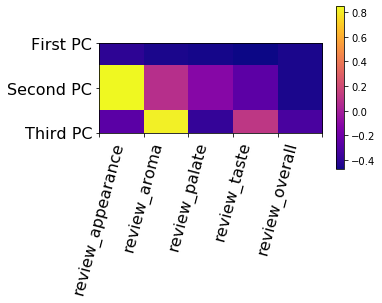

In [16]:
def plot_pca_heatmap(pca, feature_names):
    pc_names = ['First PC', 'Second PC', 'Third PC']
    fig, ax = plt.subplots(figsize=(5, 3))
    plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
    feature_names=list(feature_names)
    plt.xticks(np.arange(-0.5, 5, 1) , feature_names[0:5], rotation = 75, fontsize=16)
    plt.yticks(np.arange(0.0, 3, 1), pc_names, fontsize = 16)
    plt.colorbar()
    
features = [ 'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'review_overall']

pca = answer_pca_c()
plot_pca_heatmap(pca, features)

In [17]:
def answer_pca_e():
    result = None
    
    features = [ 'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'review_overall']
    
    pca = answer_pca_c()

    components = pca.components_
    
    df = pd.DataFrame(components, columns = features)
    
  
    df = df.abs()
    
    df = df.transpose()
    
    mapping = {df.columns[0]:'One', df.columns[1]: 'Two', df.columns[2]:'Three' }
    df = df.rename(columns=mapping)
    
    one = df[['One']].idxmax()[0] 
    two = df[['Two']].idxmax()[0] 
    three = df[['Three']].idxmax()[0]  
    
    result = (one, two, three)
    
    return result

In [18]:
# stu_ans = answer_pca_e()
# stu_ans

In [19]:
stu_ans = answer_pca_e()

assert isinstance(stu_ans, tuple), "Q1e: Your function should return a tuple of three strings. "

# Some hidden tests

del stu_ans

### 1f. Biplot interpretation.  (4 points).

Biplots are a very useful tool for simultaneously exploring a dataset and the correlation structure of its variables.  Run the provided biplot routine on the results of your PCA to answer the following questions.

1. Which variable is most correlated with PC 1?  Put the name of this variable in the first element of a list. (We'll accept either of two possible answers)

2. Which variable is most correlated with PC 2?  Put the name of this variable in the second element of a list.

3. Which variable has a higher correlation with review_aroma: review_palate, or review_taste?

4. Which variable has close to zero correlation with review_overall?


Place your answers (each of which will be a variable name starting with review_ ...) in a single tuple as strings, in the order of the questions above. Thus, your function should return a tuple of 4 strings containing your answers.


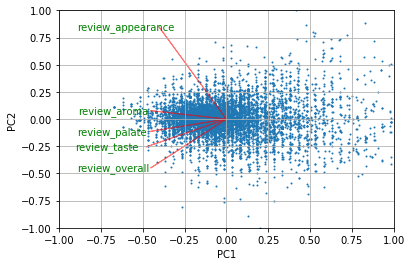

In [20]:
## Routine to generate a high-quality biplot
def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    scalex = 2.0/(xs.max()- xs.min())
    scaley = 2.0/(ys.max()- ys.min())
    text_scale_factor = 1.5
    plt.scatter(xs*scalex, ys*scaley, s=1)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5) 
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2] * text_scale_factor, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2], labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

plt.figure()

#Uncomment this code to generate the biplot using your previous answers
features = [ 'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'review_overall']
X_beer_normalized = answer_pca_a()
pca = answer_pca_c()
X_beer_pca = pca.transform(X_beer_normalized)
biplot(X_beer_pca, np.transpose(pca.components_[0:2, :]), 5, 1, 2, labels=features)

In [21]:
def answer_pca_f():
    
    result = ('review_aroma', 'review_appearance', 'review_palate', 'review_appearance')


    
    return result

In [22]:
stu_ans = answer_pca_f()

assert isinstance(stu_ans, tuple), "Q1f: Your function should return a tuple. "
assert len(stu_ans) == 4, "Q1f: Your tuple should have four strings containing your answers to the four questions, in order. "

# Some hidden tests

del stu_ans

## Question 2. (15 points) Find outliers in the beer dataset using UMAP.
In this two-part question we're going to look at outlier detection - a widely-used application of unsupervised learning. The goal will be to find individual examples or groups of beers with unusual combinations of attribute review scores relative to an "average" beer in the dataset. To do that you'll apply the UMAP algorithm mentioned in the manifold learning lecture, combined with the Local Outlier Factor algorithm in scikit-learn. Details are in the next two parts below. We've provided all the utility routines you'll need for plotting and interpreting the outliers. The UMAP library is not part of scikit-learn but you should have it preinstalled in the online enviroment. 

Details on UMAP, including how to install locally, at: https://umap-learn.readthedocs.io/en/latest/

#### The following plotting routines will be helpful for you to visualize and interpret your results.

In [23]:
# plot a labelled scatterplot
def scatter_text(x, y, text_column, color=None):
    
    fig = plt.gcf()
    fig.set_size_inches(9, 9)
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, size = 32, legend=False)
    
    # Add text besides each point
    for line in range(0,x.shape[0]):
         p1.text(x[line], y[line], 
                 text_column[line], 
                 horizontalalignment='left', 
                 size='medium', color=color, weight='semibold')
    # Set title and axis labels
    #plt.title(title)
    #plt.xlabel(xlabel)
    #plt.ylabel(ylabel)
    return p1

# randomly jitter the input points
def rand_jitter(arr):
    stdev = .03*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev


# Given a reference vector of feature values, compares the given outlier vector
# against the corresponding reference values and prints a summary of any differences.

def interpret_component(reference, outlier, label, name, index):
    epsilon = 0.5
    if (outlier[index] > reference[index] + epsilon):
        print("{} has a much higher {} rating ({:2f}).".format(label,name, outlier[index]))
    else:
        if (outlier[index] < reference[index] - epsilon):
            print("{} has a much lower {} rating ({:2f}).".format(label,name, outlier[index]))

def print_outlier_interpretation(reference, outlier, label):
    #'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'review_overall']
    interpret_component(reference, outlier, label, "appearance", 0)
    interpret_component(reference, outlier, label, "aroma", 1)
    interpret_component(reference, outlier, label, "palate", 2)
    interpret_component(reference, outlier, label, "taste", 3)
    interpret_component(reference, outlier, label, "overall", 4)

def compute_outlier_component_label(reference, outlier, index, base_label):
    epsilon = 0.5
    if (outlier[index] > reference[index] + epsilon):
        return "+{} ".format(base_label)
    if (outlier[index] < reference[index] - epsilon):
        return "-{} ".format(base_label)
    return ""
    
def compute_outlier_label(reference, outlier):
    epsilon = 0.5
    label = ""
    label = label + compute_outlier_component_label(reference, outlier, 0, "appearance")
    label = label + compute_outlier_component_label(reference, outlier, 1, "aroma")
    label = label + compute_outlier_component_label(reference, outlier, 2, "palate")
    label = label + compute_outlier_component_label(reference, outlier, 3, "taste")
    label = label + compute_outlier_component_label(reference, outlier, 4, "overall") 
    if (label == ""):
        label = "average"
    return label

### 2a. (5 points) Run UMAP to perform dimensionality reduction and neighborhood analysis on the grouped, normalized beer dataset. 

You create an instance of a UMAP object as follows:

`import umap.umap_ as umap`

`umap_obj = umap.UMAP(*..your parameters here..*)`

NOTE: use the UMAP parameters *set_op_mix_ratio=0.15, random_state = 0*.  (The somewhat magical set_op_mix_ratio parameter controls how much local vs global information UMAP uses to optimize its solution. When we look for outliers, we want to preserve some global distance structure in the solution. See the UMAP paper in the references for more details.)

To prepare the input for the UMAP `fit` method, do the following steps:

1. Start with the X_beer_normalized result you computed for Question 1. 
2. Take the first *200* rows of this result (for performance reasons) and pass this to the UMAP fit method.

Your function should simply return the UMAP object after it's been fit using these grouped, normalized beer scores as input.

In [24]:
import umap.umap_ as umap

def answer_outlier_a():
    result = None
    
    X_beer_normalized_subsample = answer_pca_a()[0:200]
    
    umap_obj = umap.UMAP(set_op_mix_ratio=0.15, random_state=0).fit(X_beer_normalized_subsample)
    
    result = umap_obj
    
    return result

In [25]:
# stu_ans = answer_outlier_a()
# stu_ans

In [26]:
stu_ans = answer_outlier_a()

assert isinstance(stu_ans, umap.UMAP), "Q2a: Your function should return a umap.UMAP object. "
assert (stu_ans.embedding_.shape == (200, 2)), "Q2a: Your fitted UMAP object should have an embedding_ property of shape (200, 2)."

# Some hidden tests

del stu_ans

### 2b. (10 points) Find outliers using the Local Outlier Factor (LOF) algorithm.

The Local Outlier Factor (LOF) algorithm is an unsupervised learning method that does outlier detection, which means finding unusual points within a given dataset that are apart in some sense from other points in the same dataset. We applied UMAP first in order to reduce the dimensionality of the problem to just two dimensions, because the LOF algorithm searches the neighborhood of each point, which is a much more expensive operation in higher dimensions.

The LOF algorithm works by computing the local density deviation of a given data point with respect to its neighbors. An outlier group is a group of samples that have much lower density than their neighbors. 

Note that outlier detection is *different* from novelty detection, which tries to *predict* outliers when given *new* data instances not in the training set. You can LOF for novelty detection but that's beyond the scope of this assignment.

The LOF parameter n_neighbors is "typically set 1) greater than the minimum number of samples a cluster has to contain, so that other samples can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by samples that can potentially be local outliers. In practice, such information is generally not available, and taking n_neighbors=20 appears to work well in general."

For this problem, when creating the LOF object *set n_neighbors = 10*.  The input to the LOF fit method is the embedding generated by UMAP.

After fitting, the LOF class computes an output array `negative_outlier_factor_` which scores each input instance: values that are large-magnitude negative numbers are considered outliers, while points with a negative outlier score close to -1 are considering "inliers" or points that have lots of nearby points and are thus not outliers.

Your function should return the row indices to the top 20 *outliers* according to the negative_outlier_factor_ scores, sorted by ascending value from lowest to highest score. 

For fun you can take your results and run them through our interpretation code to plot them and show why they're considered outliers (see below). The plot will show how the outliers group together by shared +/- qualities.


In [27]:
from sklearn.neighbors import LocalOutlierFactor

def answer_outlier_b():
    result = None
    lof =  LocalOutlierFactor(n_neighbors=10)
    lof_fit = lof.fit(answer_outlier_a().embedding_)
    
    lof_negative_outler_factor = lof_fit.negative_outlier_factor_
    
    result = lof_negative_outler_factor
    
    result = np.array(result)
    
    result = np.argsort(result)
    
    result = result[0:20]
    
    
    return result

In [28]:
# stu_ans = answer_outlier_b()
# stu_ans

In [29]:
stu_ans = answer_outlier_b()

assert isinstance(stu_ans, np.ndarray), "Q2b: Your function should return an np.ndarray. "
assert stu_ans.shape == (20,), "Q2b: Your array should have 20 elements."

# Some hidden tests

del stu_ans

#### Use the following code to plot and interpret your results

Aecht Schlenkerla Rauchbier Märzen:+aroma +palate +taste  has a much higher aroma rating (1.022962).
Aecht Schlenkerla Rauchbier Märzen:+aroma +palate +taste  has a much higher palate rating (0.509417).
Aecht Schlenkerla Rauchbier Märzen:+aroma +palate +taste  has a much higher taste rating (0.658757).
AleSmith Grand Cru Ale:+appearance +aroma +taste  has a much higher appearance rating (0.590276).
AleSmith Grand Cru Ale:+appearance +aroma +taste  has a much higher aroma rating (0.874628).
AleSmith Grand Cru Ale:+appearance +aroma +taste  has a much higher taste rating (0.680404).
't Gaverhopke Zingende Blondine:-appearance +aroma +palate +taste  has a much lower appearance rating (-1.335963).
't Gaverhopke Zingende Blondine:-appearance +aroma +palate +taste  has a much higher aroma rating (1.433732).
't Gaverhopke Zingende Blondine:-appearance +aroma +palate +taste  has a much higher palate rating (0.628127).
't Gaverhopke Zingende Blondine:-appearance +aroma +palate +taste  has a muc

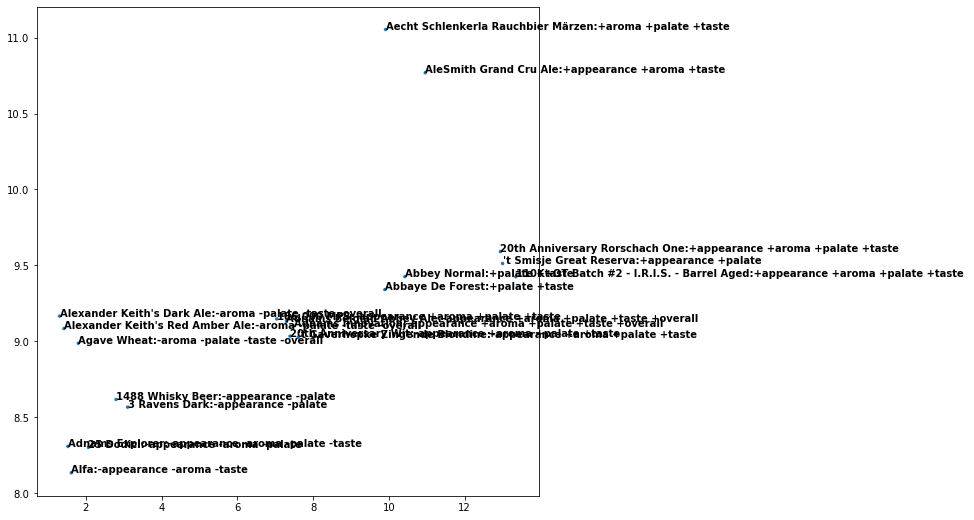

In [30]:
umap_obj                    = answer_outlier_a()
outlier_list                = answer_outlier_b()
pca_a_solution              = answer_pca_a()
X_beer_normalized_subsample = pca_a_solution[0:200]

X_beer_dimred = umap_obj.transform(X_beer_normalized_subsample)

# Reconstitute the correct beer names of the grouped data
raw_feature_names = ['beer_name', 'review_appearance', 'review_aroma', 'review_palate', 'review_taste', 'review_overall']

df_group = df[raw_feature_names].groupby('beer_name').mean()
beer_names = np.array(df_group.index)[0:200]

# create the interpretation labels for the selected beers
mean_zero = np.array([0,0,0,0,0])
beer_labels = beer_names
for outlier in outlier_list:
    beer_labels[outlier] = beer_labels[outlier] + ":"+ compute_outlier_label(mean_zero, 
                                                                             X_beer_normalized_subsample[outlier])
    print_outlier_interpretation(mean_zero, 
                                 X_beer_normalized_subsample[outlier], 
                                 beer_names[outlier])
    
scatter_text(rand_jitter(X_beer_dimred[outlier_list, 0]), 
             rand_jitter(X_beer_dimred[outlier_list, 1]), 
             beer_labels[outlier_list], 'black')

## Question 3. Using t-SNE, PCA, MDS to explore a dataset (15 points)

To get more insight into what properties of high-dimensional data are preserved, or not, with different manifold learning methods, we're going to apply several to a dataset with a variety of known cluster shapes. First, run the code below to create and plot this dataset.

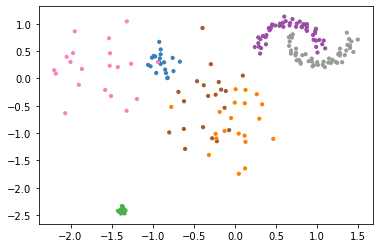

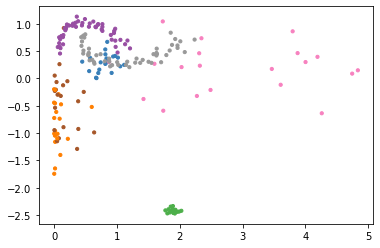

In [31]:
from sklearn import cluster, datasets
from itertools import cycle, islice
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# The goal of this routine is to create a dataset with
# a variety of clusters with very different properties:
# small and dense, large and sparse, crescent-derived, etc.
def create_complex_labeled_clusters():

    n_samples = 100
    random_state = 42

    # blobs with varied variances
    X_blobs, y_blobs = datasets.make_blobs(n_samples=n_samples, 
                                       centers = 5, n_features = 2,
                                       cluster_std=[1.0, 2.5, 0.2, 3.0, 3.0],
                                       random_state=random_state)


    X_moons, y_moons = datasets.make_moons(n_samples = 100, 
                                       noise = 0.1, random_state = random_state)
    X_moons = X_moons * 3 + [10, 10]
    y_moons = y_moons + 5

    X_raw = np.vstack((X_blobs, X_moons))
    y     = np.append(y_blobs, y_moons)

    X_scaled = StandardScaler().fit(X_raw).transform(X_raw) 

    # now expand to a higher-dimensional space with a non-linear transformation just for good measure
    poly = PolynomialFeatures(3, include_bias = False)

    X = poly.fit_transform(X_scaled)
    
    return(X, y)

X, y = create_complex_labeled_clusters()

colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y) + 1))))

# one view
plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
plt.show()

# another view
plt.scatter(X[:, 2], X[:, 1], s=10, color=colors[y])
plt.show()

### 3a. (10 points) Run dimensionality reduction methods on the data

Create PCA, t-SNE, and MDS objects with default parameters, fit them to the complex dataset *to output two (2) components*, and transform the complex clusters dataset into this 2-dimensional space. 
*Note: wherever random_state is used, set random_state = 42*
    
Your function should return a tuple (X_pca, X_tsne, X_mds) with the three versions of the original transformed, complex dataset, obtained by using fit_transform. Each transformed version should have the same number of rows as the input, but only two columns.

In [32]:
from sklearn.manifold import TSNE
from sklearn.manifold import MDS 
def answer_manifold_a():
    result = None
    
    pca = PCA(n_components = 2, random_state = 42).fit_transform(create_complex_labeled_clusters()[0])
    tsne = TSNE(n_components = 2, random_state = 42).fit_transform(create_complex_labeled_clusters()[0])
    mds = MDS(n_components = 2, random_state = 42).fit_transform(create_complex_labeled_clusters()[0])
    
    result = (pca, tsne, mds)
    return result


In [33]:
# stu_ans = answer_manifold_a()
# stu_ans

In [34]:
# Autograder tests

stu_ans = answer_manifold_a()

assert isinstance(stu_ans, tuple), "Q3a: Your function should return a tuple."

assert isinstance(stu_ans[0], np.ndarray), "Q3a: Your function should return an np.ndarray in element 0. "
assert isinstance(stu_ans[1], np.ndarray), "Q3a: Your function should return an np.ndarray in element 1. "
assert isinstance(stu_ans[2], np.ndarray), "Q3a: Your function should return an np.ndarray in element 2. "

assert stu_ans[0].shape == (200, 2), "Q3a: Your PCA np.ndarray is of an incorrect shape. "
assert stu_ans[1].shape == (200, 2), "Q3a: Your t-SNE np.ndarray is of an incorrect shape. "
assert stu_ans[2].shape == (200, 2), "Q3a: Your MDS np.ndarray is of an incorrect shape. "

# Some hidden tests

del stu_ans

### 3b.  Interpreting plotted results (5 points).

The goal for this part of the question is to compare the results visually in order to understand how cluster properties are affected differently by each method. This is important to understand before attempting to use them as preprocessing steps for other machine learning methods (such as clustering or classification).

Step 1. Uncomment the code below to plot all three versions of the dimensionality-reduced dataset.

Step 2. Examine the plots, and answer the following True/False questions.  

Your function should return a *tuple* of "T" or "F" strings with your answers. For example, if your answers are True, True, False then your function should return the tuple ("T", "T", "F").

Question 0:  t-SNE approximately preserves the density of each cluster.

Question 1:  MDS approximately preserves relative distances between clusters.

Question 2:  t-SNE approximately preserves relative distances between clusters.

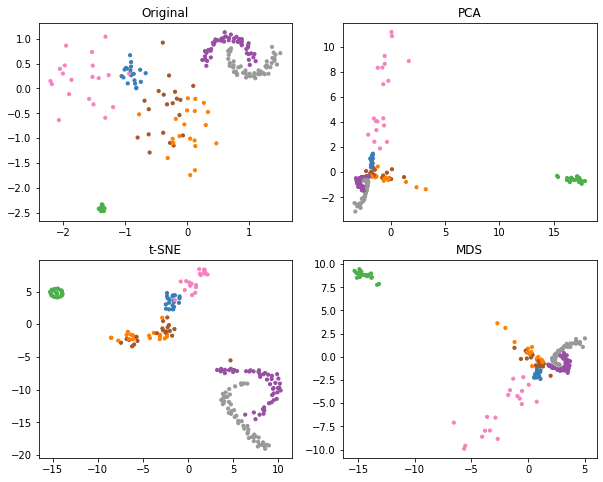

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

X_pca, X_tsne, X_mds = answer_manifold_a()

axes[0, 0].scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], s=10, color=colors[y])
axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], s=10, color=colors[y])
axes[1, 1].scatter(X_mds[:, 0], X_mds[:, 1], s=10, color=colors[y])

axes[0, 0].set_title("Original")
axes[0, 1].set_title("PCA")
axes[1, 0].set_title("t-SNE")
axes[1, 1].set_title("MDS")
del fig, axes

In [36]:
def answer_manifold_b():
    result = None

    result = ("F", "T", "F")
    
    return result

In [37]:
# Autograder tests
stu_ans = answer_manifold_b()

assert isinstance(stu_ans, tuple), "Q3b: Your function should return a tuple."
assert len(stu_ans) == 3, "Q3b: Your function should return a tuple with three elements."

# Some hidden tests

del stu_ans

## Question 4. Density estimation (30 points)
In this question you'll use the following health study dataset to estimate the probability density of individual variables (features). This is useful for a variety of reasons, but one particular widely-used application is to build classifiers that use the resulting density-based features. (The Naive Bayes classifier is one example of this.) To see what this means, in the last part of the question you'll use one of the density-based features to create a simple classifier that predicts the probability that someone has a medical condition.


Coronary Risk Factor Study (CORIS)  Rousseauw et al 1983.
(CHD stands for Coronary Heart Disease.)
Details in Hastie and Tibshirani (1987).

A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of CHD. Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in  Rousseauw et al, 1983, South African Medical
Journal.

| Attribute | Additional Description |
| :- | :- | 
| `sbp` | systolic blood pressure |
| `ldl` | low density lipoprotein cholesterol |
| `adiposity` |  |
| `famhist` | family history of heart disease (Present, Absent) |
| `typea` | type-A behavior |
| `obesity` |  |
| `alcohol` | current alcohol consumption |
| `age` | age at onset |
| `chd` | response, coronary heart disease |

### 4a. (5 points)
Read the file `assets/mads_SAHeart.csv` into a dataframe. Then partition this into two dataset variables:

    X_sbp_chd which selects the single feature 'sbp' from all rows with chd == 1
    X_sbp_nochd which selects the single feature 'sbp' from all rows with chd == 0
    
Your function should return these two variables as a tuple (X_sbp_chd, X_sbp_nochd). Each tuple entry should be a numpy ndarray with exactly 1 column (the 'sbp' feature value).
    

In [38]:
def answer_kde_a():
    
    result = None
    
    south_africa_df = pd.read_csv('assets/mads_SAHeart.csv')
    
    is_1 =  south_africa_df['chd']==1
    is_0 = south_africa_df['chd']==0
    
    X_sbp_chd = south_africa_df[is_1]
    X_sbp_chd = X_sbp_chd['sbp'].to_numpy()
    X_sbp_chd = X_sbp_chd.reshape(160, 1)
    
    X_sbp_nochd = south_africa_df[is_0]
    X_sbp_nochd =  X_sbp_nochd['sbp'].to_numpy()
    X_sbp_nochd = X_sbp_nochd.reshape(302, 1)
    
    result = (X_sbp_chd, X_sbp_nochd)
    
    return result
    

In [39]:
# stu_ans = answer_kde_a()
# stu_ans

In [40]:
# Autograder tests

stu_ans = answer_kde_a()

assert isinstance(stu_ans, tuple), "Q4a: Your function should return a tuple."
assert isinstance(stu_ans[0], np.ndarray), "Q4a: Your function should return an np.ndarray in element 0. "
assert isinstance(stu_ans[1], np.ndarray), "Q4a: Your function should return an np.ndarray in element 1. "
assert stu_ans[0].shape == (160, 1), "Q4a: Your X_sbp_chd np.ndarray is of an incorrect shape. "
assert stu_ans[1].shape == (302, 1), "Q4a: Your X_sbp_nochd np.ndarray is of an incorrect shape. "

# Some hidden tests

del stu_ans

### 4b. Applying Kernel Density Estimation (10 points)

Recall that Kernel Density Estimation (KDE) is a non-parametric method: it is memory-based (sometimes called instance-based) learning, meaning that we don't assume the density has a simple, parametric form like a Gaussian. Instead, as we saw for other methods like k-nearest neighbor, the density model itself is defined by the entire training set: KDE first applies a kernel function around every point, to "smooth it out". The width of the kernel function, and thus, the degree of smoothing, is parametrized by a "bandwidth" parameter. A Gaussian is often used as the kernel function, so for this question, we'll apply a *Gaussian kernel function* to every point, centred on the point, *with bandwidth parameter 5*. With that configuration, compute two kernel density estimates based on the `sbp` variable, for (a) subjects with CHD and (b) subjects without CHD.

Your function should return a tuple with two elements. The first and second elements, respectively, are the result (the log density values) of the "score_samples" method on the CHD density and non-CHD density. These should each be a numpy array of shape (400,), since the input to the score_samples method in both cases should be an array of 400 points, evenly spaced starting at 100 up to a maximum of 220. 

In [41]:
from sklearn.neighbors import KernelDensity
def answer_kde_b():
    samples = np.linspace(100, 220, 400)
    samples = samples.reshape(400,1)
    kde_chd = KernelDensity(kernel='gaussian', bandwidth=5).fit(answer_kde_a()[0])
    scores_chd = kde_chd.score_samples(samples)
    
    kde_nochd = KernelDensity(kernel='gaussian', bandwidth=5).fit(answer_kde_a()[1])
    scores_nochd = kde_nochd.score_samples(samples)

    result = (scores_chd, scores_nochd)
    

    return result

In [42]:
# stu_ans = answer_kde_b()
# stu_ans

In [43]:
# Autograder tests

stu_ans = answer_kde_b()

assert isinstance(stu_ans, tuple), "Q4b: Your function should return a tuple."

assert isinstance(stu_ans[0], np.ndarray), "Q4b: Your function should return an np.ndarray in element 0. "
assert isinstance(stu_ans[1], np.ndarray), "Q4b: Your function should return an np.ndarray in element 1. "

assert stu_ans[0].shape == (400,), "Q4b: Your first array has an incorrect shape. "
assert stu_ans[1].shape == (400,), "Q4b: Your second array has an incorrect shape. "

# Some hidden tests

del stu_ans

You can use the function below to plot the densities you've created.

In [44]:
def plot_densities(X_plot, class1, class2):
    plt.clf()
    plt.plot(X_plot, class1, color = 'g', label = 'No CHD')
    plt.plot(X_plot, class2, color="r", label = 'CHD')
    plt.title('Density Plot of Systolic Blood Pressure')
    plt.xlabel('Systolic Pressure')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

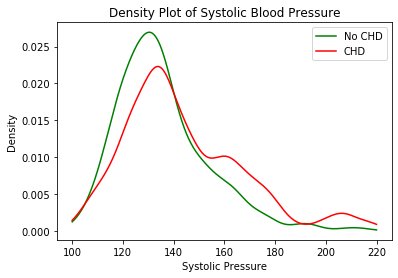

In [45]:
# Uncomment this to plot
X_plot = np.linspace(100, 220, num=400)
(log_dens_chd, log_dens_nochd) = answer_kde_b()
plot_densities(X_plot, np.exp(log_dens_nochd), np.exp(log_dens_chd))

### 4c. Binary classification using density estimates (15 points)

Now we'll use the density estimates you computed for the systolic pressure feature to build a very simple probabilistic Bayesian binary classifier that predicts one of two classes: $c_{CHD}$ or $c_{notCHD}$, based on that single `sbp` feature alone. When you computed the density estimate you already trained the classifier: by learning the density you can now compute (with the score_samples method) the quantities $\log p(x | c_{CHD})$ and $\log p(x | c_{notCHD})$ where $x$ is the `sbp` feature, using the score_samples method of the density estimator

But if we want to predict the class of a new patient with a value $x_{NEW}$ for `sbp` systolic pressure, the classifier will need to compute $p(c_{CHD} | x)$ and $p(c_{notCHD} | x)$, and then output the class with highest probability for its prediction. How can we get $p(c_{CHD} | x)$ from $\log p(x | c_{CHD})$ ?

Bayes' rule to the rescue! According to Bayes' rule, we have

$$p(c_{CHD} | x) = \frac{p(x | c_{CHD}) \cdot p(c_{CHD})}{p(x)}. $$
and
$$p(c_{notCHD} | x) = \frac{p(x | c_{notCHD}) \cdot p(c_{notCHD})}{p(x)}. $$

As a reminder, the quantity $p(c_{CHD})$ is called the *class prior*.  It reflects our belief that a patient has CHD before we see any specific individual evidence about them (e.g. from our knowledge of the general population perhaps). The quantity $p(c_{CHD} | x)$ is called the *class posterior* because it reflects an updated belief about whether or not the patient has CHD after seeing their systolic pressure observation $x$.

Taking logarithms of both sides gives us

$$\log p(c_{CHD} | x) = \log p(x | c_{CHD}) + \log p(c_{CHD}) - \log p(x). $$
and
$$\log p(c_{notCHD} | x) = \log p(x | c_{notCHD}) + \log p(c_{notCHD}) - \log p(x). $$

Goal accomplished. Now we just need to compute each of the above class predictions and select the class that gives the log probability that is greater. Note that the term $\log p(x)$ is subtracted in both prediction formulas, so will not affect our decision and we can remove it.  Thus we just need to compute

$$\log p(c_{CHD} | x) \propto \log p(x | c_{CHD}) + \log p(c_{CHD})$$
and
$$\log p(c_{notCHD} | x) \propto \log p(x | c_{notCHD}) + \log p(c_{notCHD})$$


For this question, we'll assume that the prior $p(c_{CHD}) = 0.5$ for this group of patients, assuming they have already been referred to a specialist. (This doesn't reflect reality in the general case and you should experiment with different choices of lower-probability prior to see the effect on classification results.)

You can get a small test dataset by calling the given function `get_chd_test_data`. Your function should return a float that is the accuracy score of your Bayesian classifier on the provided test examples. (Just a single prediction, not using cross-validation.)

In [46]:
def get_chd_test_data():
    # column 0 is 'sbp' feature, column 1 is CHD label (=1 if CHD, else 0)
    result = np.array([[200, 1], [169, 1], [120, 0], [135, 1], [142, 0], [143, 1], [150, 1], [162, 1], [100, 0], [112, 0]])
    return result

In [50]:
from sklearn.metrics import accuracy_score
def answer_kde_c():
    
    
    data = get_chd_test_data().tolist()
    
    data_no_labels = []
    
    
    for i in data:
        for j in i:
            data_no_labels.append(j)
            
            
    data_no_labels = data_no_labels[::2]
    data_no_labels = np.array(data_no_labels).reshape(10,1)
    
    
    
    kde_chd = KernelDensity(kernel='gaussian', bandwidth=5).fit(answer_kde_a()[0])
    scores_chd = kde_chd.score_samples(data_no_labels)
    
    kde_nochd = KernelDensity(kernel='gaussian', bandwidth=5).fit(answer_kde_a()[1])
    scores_nochd = kde_nochd.score_samples(data_no_labels)
    
    labels_predicted = []
    p = None
    for i in scores_chd:
        for j in scores_nochd:
            if i < j:
                 p = 1
            else:
                 p = 0
        labels_predicted.append(p)


    
    labels_true = []
    
    for i in data:
        for j in i:
            labels_true.append(j)
            
    labels_true =  labels_true[1::2]
    labels_true = np.array(labels_true).reshape(10,1)
    
    accuracy = accuracy_score(labels_true, labels_predicted)
    
    result = accuracy 
    
    return result
  

In [51]:
# stu_ans = answer_kde_c()
# stu_ans

0.5

In [49]:
# Autograder tests

stu_ans = answer_kde_c()

assert isinstance(stu_ans, (float, np.floating)), "Q4c: Your function should return a float."

# Some hidden tests

del stu_ans